In [1]:
#! pip install xgboost==1.4.2

In [38]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score

In [3]:
inoutpath = '/home/xiaopengxu/Desktop/data-covid-review/2021-05-11/'

train_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_train.csv'
test_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_test.csv'

## Load data

In [4]:
def load_data(compdata_path):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Loading data ...")
    papers = pd.read_csv(compdata_path, index_col=False)
    papers.drop(['Unnamed: 0'], axis=1, inplace=True)

    return papers

In [5]:
X = load_data(train_data_path)
X_lxd = load_data(test_data_path)

2021-05-15 23:02:54.448055: Loading data ...
2021-05-15 23:02:55.096689: Loading data ...


/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
y = X.is_published

In [7]:
print(X.columns.values)

['title' 'abstract' 'journal' 'DOI' 'date' 'collection' 'published'
 'nauthors' 'keywords' 'topic.Drug discovery' 'topic.Clinics'
 'topic.Healthcare' 'topic.Imaging' 'topic.Genomics' 'topic.Epidemiology'
 'topic' 'ref' 'p_doi' 'dv 1' 'dv 2' 'dv 3' 'dv 4' 'dv 5' 'dv 6' 'dv 7'
 'dv 8' 'dv 9' 'dv 10' 'dv 11' 'dv 12' 'dv 13' 'dv 14' 'dv 15' 'dv 16'
 'dv 17' 'dv 18' 'dv 19' 'dv 20' 'dv 21' 'dv 22' 'dv 23' 'dv 24' 'dv 25'
 'dv 26' 'dv 27' 'dv 28' 'dv 29' 'dv 30' 'dv 31' 'dv 32' 'dv 33' 'dv 34'
 'dv 35' 'dv 36' 'dv 37' 'dv 38' 'dv 39' 'dv 40' 'dv 41' 'dv 42' 'dv 43'
 'dv 44' 'dv 45' 'dv 46' 'dv 47' 'dv 48' 'dv 49' 'dv 50' 'dw 1' 'dw 2'
 'dw 3' 'dw 4' 'dw 5' 'dw 6' 'dw 7' 'dw 8' 'dw 9' 'dw 10' 'dw 11' 'dw 12'
 'dw 13' 'dw 14' 'dw 15' 'dw 16' 'dw 17' 'dw 18' 'dw 19' 'dw 20' 'dw 21'
 'dw 22' 'dw 23' 'dw 24' 'dw 25' 'dw 26' 'dw 27' 'dw 28' 'dw 29' 'dw 30'
 'dw 31' 'dw 32' 'dw 33' 'dw 34' 'dw 35' 'dw 36' 'dw 37' 'dw 38' 'dw 39'
 'dw 40' 'dw 41' 'dw 42' 'dw 43' 'dw 44' 'dw 45' 'dw 46' 'dw 47' 'dw 4

## Evaluate features

In [8]:
em_size = 50
F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Imaging', 'topic.Genomics']
F_Doc2Vec = ['dv ' + str(i + 1) for i in range(em_size)]
F_DeepWalk = ['dw ' + str(i + 1) for i in range(em_size)]
F_ascore = ['auth.papers.score', 'auth.citations.score']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [10]:
def eval_pred(y_true, y_prob):

    y_pred = y_prob >= 0.5
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_s = auc(fpr, tpr)

    prec, recall, f1_s, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    
    print("AUC = %.3f, precision = %.3f, recall = %.3f, accuracy = %.3f, f1_score = %.3f" % (auc_s, prec, recall, acc, f1_s))

In [11]:
def XGBoost_Modeling(features):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

    xg_reg.fit(X_train[features],y_train)

    preds = xg_reg.predict(X_test[features])
    eval_pred(y_test, preds)
    
    return xg_reg

In [12]:
def list_exclude(a, b):
    return [x for x in a if x not in b ]

In [13]:
F_all = F_LDA + F_Doc2Vec + F_DeepWalk + F_ascore

XGBoost_Modeling(F_all)
XGBoost_Modeling(list_exclude(F_all, F_LDA)) 
XGBoost_Modeling(list_exclude(F_all, F_Doc2Vec))
XGBoost_Modeling(list_exclude(F_all, F_DeepWalk))
XGBoost_Modeling(list_exclude(F_all, F_ascore)) # best result

AUC = 0.739, precision = 0.781, recall = 0.606, accuracy = 0.778, f1_score = 0.614
AUC = 0.731, precision = 0.762, recall = 0.594, accuracy = 0.770, f1_score = 0.597
AUC = 0.723, precision = 0.762, recall = 0.606, accuracy = 0.775, f1_score = 0.614
AUC = 0.733, precision = 0.723, recall = 0.529, accuracy = 0.743, f1_score = 0.487
AUC = 0.733, precision = 0.790, recall = 0.612, accuracy = 0.781, f1_score = 0.622


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=64, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
F_new = F_LDA + F_Doc2Vec + F_DeepWalk 

XGBoost_Modeling(F_new) # Best result
XGBoost_Modeling(list_exclude(F_new, F_Doc2Vec)) 
XGBoost_Modeling(list_exclude(F_new, F_DeepWalk))
XGBoost_Modeling(list_exclude(F_new, F_LDA))

AUC = 0.733, precision = 0.790, recall = 0.612, accuracy = 0.781, f1_score = 0.622
AUC = 0.701, precision = 0.771, recall = 0.604, accuracy = 0.776, f1_score = 0.612
AUC = 0.732, precision = 0.701, recall = 0.522, accuracy = 0.739, f1_score = 0.474
AUC = 0.720, precision = 0.755, recall = 0.596, accuracy = 0.770, f1_score = 0.600


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=64, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
def draw_ROC_figure(fprs, tprs, f_names, aucs):
    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    
    for i in range(len(f_names)):
        plt.plot(fprs[i], tprs[i], label= f_names[i] +', AUC={:.4f}'.format(aucs[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.draw()

In [15]:
from sklearn.metrics import average_precision_score

xg_reg = XGBoost_Modeling(F_new) # Best result
X_test['pub_prob'] = xg_reg.predict(X_test[F_new])

average_precision = average_precision_score(y_test, X_test.pub_prob)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

AUC = 0.733, precision = 0.790, recall = 0.612, accuracy = 0.781, f1_score = 0.622
Average precision-recall score: 0.87


<ipython-input-15-a36efc31732f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pub_prob'] = xg_reg.predict(X_test[F_new])


AUC = 0.723, precision = 0.673, recall = 0.513, accuracy = 0.735, f1_score = 0.454
AUC = 0.653, precision = 0.366, recall = 0.500, accuracy = 0.732, f1_score = 0.423
AUC = 0.674, precision = 0.366, recall = 0.500, accuracy = 0.732, f1_score = 0.423


/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC = 0.743, precision = 0.789, recall = 0.606, accuracy = 0.779, f1_score = 0.614


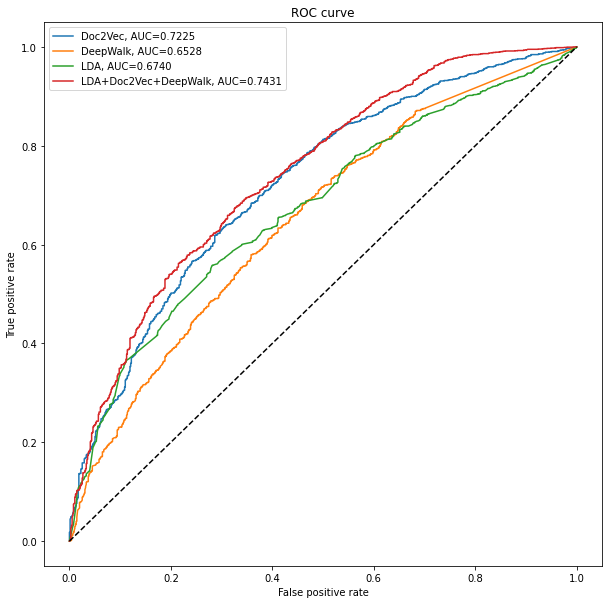

In [47]:
f_names = ['LDA+Doc2Vec+DeepWalk']
fprs, tprs, aucs = [], [], []
f_names = ['Doc2Vec', 'DeepWalk', 'LDA', 'LDA+Doc2Vec+DeepWalk']
f_combs = [F_Doc2Vec, F_DeepWalk, F_LDA,  F_Doc2Vec + F_DeepWalk + F_LDA]

for i in range(len(f_names)):
    xg_reg = XGBoost_Modeling(f_combs[i]) # Best result
    pub_prob = xg_reg.predict(X_test[f_combs[i]])

    fpr, tpr, _ = roc_curve(y_test, pub_prob)
    auc_s = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc_s)
        
draw_ROC_figure(fprs, tprs, f_names, aucs)

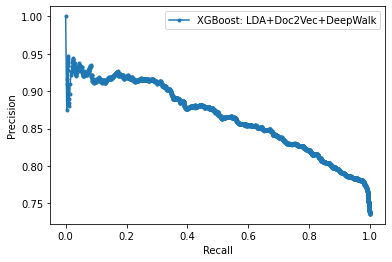

In [16]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, X_test.pub_prob)
plt.plot(recall, precision, marker='.', label='XGBoost: LDA+Doc2Vec+DeepWalk')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import classification_report
target_names = ['Unpublished', 'Published']

print(classification_report(y_test, X_test.pub_prob >=0.5, target_names=target_names))

              precision    recall  f1-score   support

 Unpublished       0.80      0.25      0.38       754
   Published       0.78      0.98      0.87      2060

    accuracy                           0.78      2814
   macro avg       0.79      0.61      0.62      2814
weighted avg       0.79      0.78      0.74      2814



## Evaluate on test data

In [18]:
X_lxd['pub_prob'] = xg_reg.predict(X_lxd[F_new])

In [19]:
len(X_lxd[X_lxd.is_published & (X_lxd.pub_prob >= 0.5)]) #[['title', 'pub_prob', 'is_published']]

13

In [20]:
len(X_lxd[X_lxd.is_published & ~(X_lxd.pub_prob>= 0.5)]) #[['title', 'pub_prob', 'is_published']]

1

In [21]:
X_lxd.to_csv(inoutpath + "ret_lxd_xgb.ori_doc2vec_deepwalk_scores.csv")

## Visualize result

In [22]:
xg_reg = XGBoost_Modeling(F_new) # Best result
X['pub_prob'] = xg_reg.predict(X[F_new])

AUC = 0.733, precision = 0.790, recall = 0.612, accuracy = 0.781, f1_score = 0.622


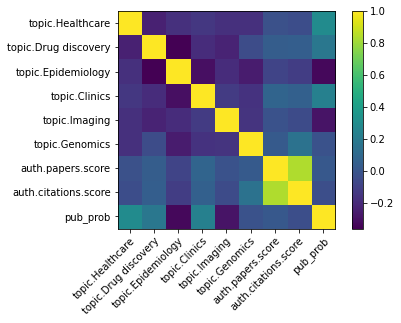

In [23]:
ticks = F_LDA + F_ascore + ['pub_prob']

fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]

ax = fig.add_subplot(111)
cax = ax.matshow(X[ticks].corr())
fig.colorbar(cax)

ax.set_xticks(np.arange(len(ticks)))
ax.set_yticks(np.arange(len(ticks)))

ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)

ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

<AxesSubplot:xlabel='topic'>

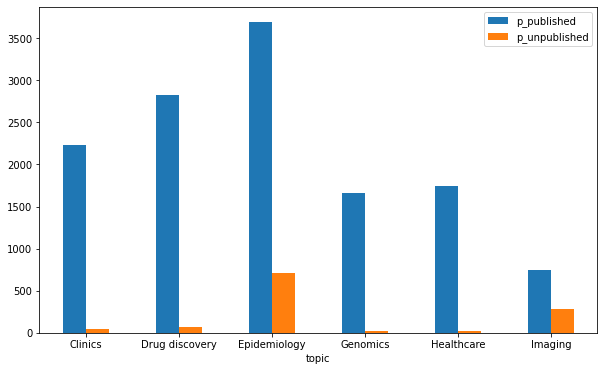

In [24]:
plt.rcParams['figure.figsize'] = [10, 6]

X['p_published'] = (X['pub_prob'] > 0.5) * 1
df_ret = pd.merge(X['topic'], X['p_published'], left_index=True, right_index=True)

topic_sum = df_ret.groupby('topic').agg({'topic':'count', 'p_published':'sum'})
topic_sum['p_unpublished'] = topic_sum['topic'] - topic_sum['p_published']
topic_sum[['p_published', 'p_unpublished']].plot.bar(rot=0)

<AxesSubplot:xlabel='topic'>

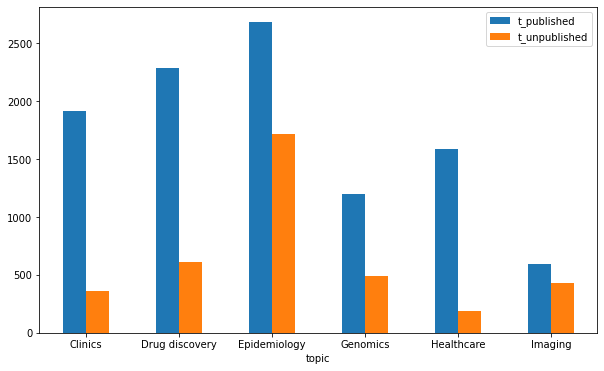

In [25]:
X['t_published'] = y * 1
df_t_ret = pd.merge(X['topic'], X['t_published'], left_index=True, right_index=True)

topic_t_sum = df_t_ret.groupby('topic').agg({'topic':'count', 't_published':'sum'})
topic_t_sum['t_unpublished'] = topic_t_sum['topic'] - topic_t_sum['t_published']
topic_t_sum[['t_published', 't_unpublished']].plot.bar(rot=0)